In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from AvaliacaoModelo import AvaliacaoModelo
from modelos.CFRecommender import *
from modelos.PopularityRecommender import PopularityRecommender
from modelos.CFRecommenderSVD import *

# Etapa de Pre-processamento

In [6]:
ratings = pd.read_csv('dataset/BX-Book-Ratings.csv', encoding='ISO-8859-1', delimiter=';')
books = pd.read_csv('dataset/BX-Books.csv', encoding='ISO-8859-1', delimiter=';', error_bad_lines=False)
users = pd.read_csv('dataset/BX-Users.csv', encoding='ISO-8859-1', delimiter=';')

b'Skipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [7]:
books = books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

book_rating = pd.merge(ratings, books, on='ISBN', how='inner')

book_rating = pd.merge(book_rating,users, on='User-ID', how='inner')

book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,"cincinnati, ohio, usa",23.0


Removendo todos os ratings iguais a zero e usuários que avaliaram menos de 4 vezes, com o intuito de criar uma matrix menos esparça

In [8]:
book_rating = book_rating[book_rating['Book-Rating']> 0]

# filtrando apenas os livros que foram avaliados mais de 9 vezes
ratings_full = book_rating.groupby('ISBN').filter(lambda x: len(x) >= 10)

# filtrando apenas os usuário que avaliaram mais de 3 vezes
ratings_full = ratings_full.groupby('User-ID').filter(lambda x: len(x) >= 4)

In [9]:
ratings_full = ratings_full.groupby(['ISBN', 'User-ID'])['Book-Rating'].mean().to_frame().reset_index()

In [10]:
ratings_full.head()

,ISBN,User-ID,Book-Rating
0,0002558122,11676,8
1,0002558122,81274,8
2,0002558122,201537,8
3,000648302X,11676,8
4,000648302X,37950,9


In [11]:
#Persistindo a base processada
ratings_full.to_csv('dataset/ratings_full.csv')

# Treinamento dos modelos

In [12]:
ratings_full = pd.read_csv('dataset/ratings_full.csv', index_col=0)
ratings_full.head()

,ISBN,User-ID,Book-Rating
0,0002558122,11676,8
1,0002558122,81274,8
2,0002558122,201537,8
3,000648302X,11676,8
4,000648302X,37950,9


In [23]:
ratings_train, ratings_test = train_test_split(ratings_full,test_size=0.20,stratify=ratings_full['User-ID'], random_state=20)

print('# avaliações de treino: %d' % len(ratings_train))
print('# avaliações no teste: %d' % len(ratings_test))

# avaliações de treino: 77037
# avaliações no teste: 19260


In [24]:
ratings_full_index = ratings_full.set_index('User-ID')
ratings_test_index = ratings_test.set_index('User-ID')
ratings_train_index = ratings_train.set_index('User-ID')

In [25]:
#Instanciando as classes dos modelos
modelo_popularidade = PopularityRecommender(ratings_full, book_rating)
treinamento_cf = CFTraing()
treinamento_svd = CFTraingSVD()

In [27]:
#Treinando os modelos colaborativos, o modelo de popularidade não precisa ser treinado
modelo_CF = CFRecommender(treinamento_cf.training_model(ratings_train), book_rating)
modelo_CF_SVD = CFRecommenderSVD(treinamento_svd.training_model(ratings_train, 20), book_rating)

# Avaliação dos modelos

In [28]:
#Instanciando a classe de avaliação dos modelos
avaliacao_modelo = AvaliacaoModelo(ratings_test_index,ratings_train_index)

In [29]:
print('Avaliando modelo de popularidade...')
pop_global_metrics, pop_detailed_results_df = avaliacao_modelo.avaliar_modelo(modelo_popularidade)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Avaliando modelo de popularidade...
7460 usuários processados

Global metrics:
{'modelName': 'Popularidade', 'recall@5': 0.00020768431983385254, 'recall@10': 0.00036344755970924193}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
66,11676,379,1,1,0.002639,0.002639
512,16795,68,0,0,0.000000,0.000000
166,98391,63,0,0,0.000000,0.000000
291,153662,60,0,0,0.000000,0.000000
656,95359,57,0,0,0.000000,0.000000
233,104636,54,0,0,0.000000,0.000000
834,114368,53,0,0,0.000000,0.000000
1019,123883,41,0,0,0.000000,0.000000
896,60244,41,0,0,0.000000,0.000000
684,158295,40,0,0,0.000000,0.000000


In [30]:
print('Avaliando modelo de filtros colaborativos...')
cf_global_metrics, cf_detailed_results_df = avaliacao_modelo.avaliar_modelo(modelo_CF)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Avaliando modelo de filtros colaborativos...
7460 usuários processados

Global metrics:
{'modelName': 'Filtros Colaborativos', 'recall@5': 0.059553478712357215, 'recall@10': 0.08312564901349948}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
66,11676,379,3,2,0.007916,0.005277
512,16795,68,1,1,0.014706,0.014706
166,98391,63,3,1,0.047619,0.015873
291,153662,60,3,2,0.050000,0.033333
656,95359,57,2,1,0.035088,0.017544
233,104636,54,3,1,0.055556,0.018519
834,114368,53,2,0,0.037736,0.000000
1019,123883,41,4,3,0.097561,0.073171
896,60244,41,1,0,0.024390,0.000000
684,158295,40,2,1,0.050000,0.025000


In [31]:
print('Avaliando modelo de filtros colaborativos SVD...')
svd_global_metrics, svd_detailed_results_df = avaliacao_modelo.avaliar_modelo(modelo_CF_SVD)
print('\nGlobal metrics:\n%s' % svd_global_metrics)
svd_detailed_results_df.head(10)

Avaliando modelo de filtros colaborativos SVD...
7460 usuários processados

Global metrics:
{'modelName': 'Filtros Colaborativos SVD', 'recall@5': 0.03520249221183801, 'recall@10': 0.0514018691588785}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
66,11676,379,2,1,0.005277,0.002639
512,16795,68,1,1,0.014706,0.014706
166,98391,63,4,3,0.063492,0.047619
291,153662,60,1,1,0.016667,0.016667
656,95359,57,1,1,0.017544,0.017544
233,104636,54,4,3,0.074074,0.055556
834,114368,53,3,1,0.056604,0.018868
1019,123883,41,3,2,0.073171,0.048780
896,60244,41,0,0,0.000000,0.000000
684,158295,40,1,1,0.025000,0.025000


In [32]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, svd_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularidade,0.000363,0.000208
Filtros Colaborativos,0.083126,0.059553
Filtros Colaborativos SVD,0.051402,0.035202


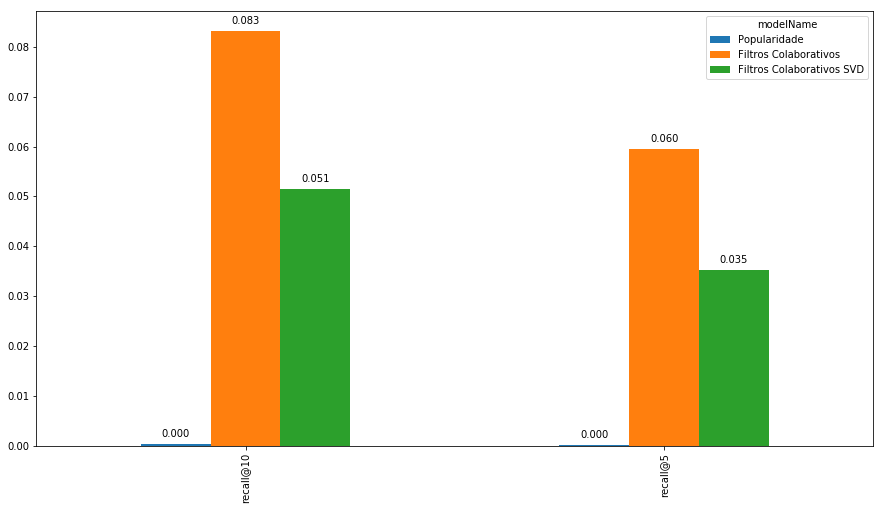

In [33]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Conclusão

Nesse notebook, eu explorei os modelos de recomendação baseados na popularidade, que pode ainda ser bastante efetivos em casos de usuários novos, que ainda não tem histórico, mas que se mostra pouco acertivo com relação a personlização da recomendação. Tambem apresentei um segundo modelo, baseado nas interações de grupos de usuários semelhantes, esse modelo nesse caso foi o que teve a melhor acurária, para os dados de teste. O terceiro modelo foi baseado na fatoração de matrizes com SVD, é um modelo bastante poderoso, mas que se mostrou menos efetivo quando aplicado em uma matriz muito esparça que foi o nosso caso.

Tentei resolver o problema da matriz esparça removendo da base as recomendações iguais a zero, não resolveu muito nesse caso. Acredito que a outra alternativa seria considera a média das avaliação do livro para as avaliação faltantes ou com zero. Ou tambem mudar a abordagem, considerando a própria interação com o livro (compra, visualização na loja virtual, etc) como uma operação válida para recomendação do produto.